# Final Four Panel Plot for July 2nd Flooding Event
## Tehreem Qureshi, SULI EVS Notebook Used for Final Poster Figures.

---

## Imports

In [20]:
import pyart
import fsspec
import glob
from metpy.plots import USCOUNTIES
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
import cartopy.crs as ccrs
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pyart.testing import get_test_data
warnings.filterwarnings("ignore")
import os
from netCDF4 import Dataset
import netCDF4
import pandas as pd
import metpy

## Accessing and Plotting NEXRAD KLOT Data for 07/02.

In [21]:
fs = fsspec.filesystem("s3", anon=True)

In [22]:
files = sorted(fs.glob("s3://noaa-nexrad-level2/2023/07/02/KLOT/KLOT20230702_*V06")) # sorting NEXRAD KLOT files in order of time 
files 

['noaa-nexrad-level2/2023/07/02/KLOT/KLOT20230702_000021_V06',
 'noaa-nexrad-level2/2023/07/02/KLOT/KLOT20230702_000431_V06',
 'noaa-nexrad-level2/2023/07/02/KLOT/KLOT20230702_000840_V06',
 'noaa-nexrad-level2/2023/07/02/KLOT/KLOT20230702_001250_V06',
 'noaa-nexrad-level2/2023/07/02/KLOT/KLOT20230702_001654_V06',
 'noaa-nexrad-level2/2023/07/02/KLOT/KLOT20230702_002058_V06',
 'noaa-nexrad-level2/2023/07/02/KLOT/KLOT20230702_002502_V06',
 'noaa-nexrad-level2/2023/07/02/KLOT/KLOT20230702_002906_V06',
 'noaa-nexrad-level2/2023/07/02/KLOT/KLOT20230702_003310_V06',
 'noaa-nexrad-level2/2023/07/02/KLOT/KLOT20230702_003728_V06',
 'noaa-nexrad-level2/2023/07/02/KLOT/KLOT20230702_004133_V06',
 'noaa-nexrad-level2/2023/07/02/KLOT/KLOT20230702_004550_V06',
 'noaa-nexrad-level2/2023/07/02/KLOT/KLOT20230702_005008_V06',
 'noaa-nexrad-level2/2023/07/02/KLOT/KLOT20230702_005425_V06',
 'noaa-nexrad-level2/2023/07/02/KLOT/KLOT20230702_005902_V06',
 'noaa-nexrad-level2/2023/07/02/KLOT/KLOT20230702_01033

In [23]:
site_lon = -87.99512386322021  #establishing ATMOS site coordinates
site_lat = 41.70178755070838 

In [24]:
def process_radar(file):
    time = file.split("/")[-1][:-4]

    radar = pyart.io.read_nexrad_archive(f's3://{file}')

    ds = pyart.util.columnsect.get_field_location(radar, site_lat, site_lon) # using ATMOS field coords

    del ds.base_time.attrs["units"]
    del ds.time_offset.attrs["units"]

    ds.to_netcdf(f"{time}.nc", mode="w", format='NETCDF4') # converting NEXRAD data into .nc files and adding base_time as an attribute 
    

In [25]:
for file in files[-37:]:
    process_radar(file)
processed_files = sorted(glob.glob("KLOT20230702_*")) # processing and sorting .nc files in order
processed_files

['KLOT20230702_000021.nc',
 'KLOT20230702_000431.nc',
 'KLOT20230702_000840.nc',
 'KLOT20230702_001250.nc',
 'KLOT20230702_001654.nc',
 'KLOT20230702_002058.nc',
 'KLOT20230702_002502.nc',
 'KLOT20230702_002906.nc',
 'KLOT20230702_003310.nc',
 'KLOT20230702_003728.nc',
 'KLOT20230702_004133.nc',
 'KLOT20230702_004550.nc',
 'KLOT20230702_005008.nc',
 'KLOT20230702_005425.nc',
 'KLOT20230702_005902.nc',
 'KLOT20230702_010339.nc',
 'KLOT20230702_010811.nc',
 'KLOT20230702_011244.nc',
 'KLOT20230702_011720.nc',
 'KLOT20230702_012204.nc',
 'KLOT20230702_012649.nc',
 'KLOT20230702_013111.nc',
 'KLOT20230702_013524.nc',
 'KLOT20230702_013942.nc',
 'KLOT20230702_014352.nc',
 'KLOT20230702_014808.nc',
 'KLOT20230702_015333.nc',
 'KLOT20230702_015757.nc',
 'KLOT20230702_020151.nc',
 'KLOT20230702_020614.nc',
 'KLOT20230702_021022.nc',
 'KLOT20230702_021445.nc',
 'KLOT20230702_021922.nc',
 'KLOT20230702_022353.nc',
 'KLOT20230702_022805.nc',
 'KLOT20230702_023250.nc',
 'KLOT20230702_023712.nc',
 

In [26]:
ds = xr.open_dataset(processed_files[1])
ds1 = xr.open_dataset(processed_files[2]) # basic chceck to open files

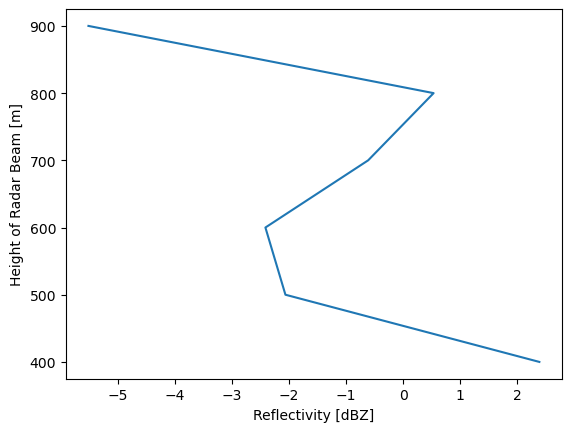

In [27]:
ds.drop_duplicates(dim='height').interp(height=np.arange(300, 5000, 100), method='linear').reflectivity.plot(y='height') # plotting reflectivity versus height

In [28]:
def expand_time(ds):
    ds = ds.drop_duplicates(dim='height').interp(height=np.arange(300, 5000, 500), method='linear').expand_dims("base_time")
    ds = ds.set_coords("base_time")
    return ds # expanding time dimension

In [29]:
ds_list = [] #appending all .nc files to list
for file in processed_files:
    ds = xr.open_dataset(file)
    ds = expand_time(ds)
    ds_list.append(ds)

In [30]:
ds = xr.concat(ds_list, dim='base_time')

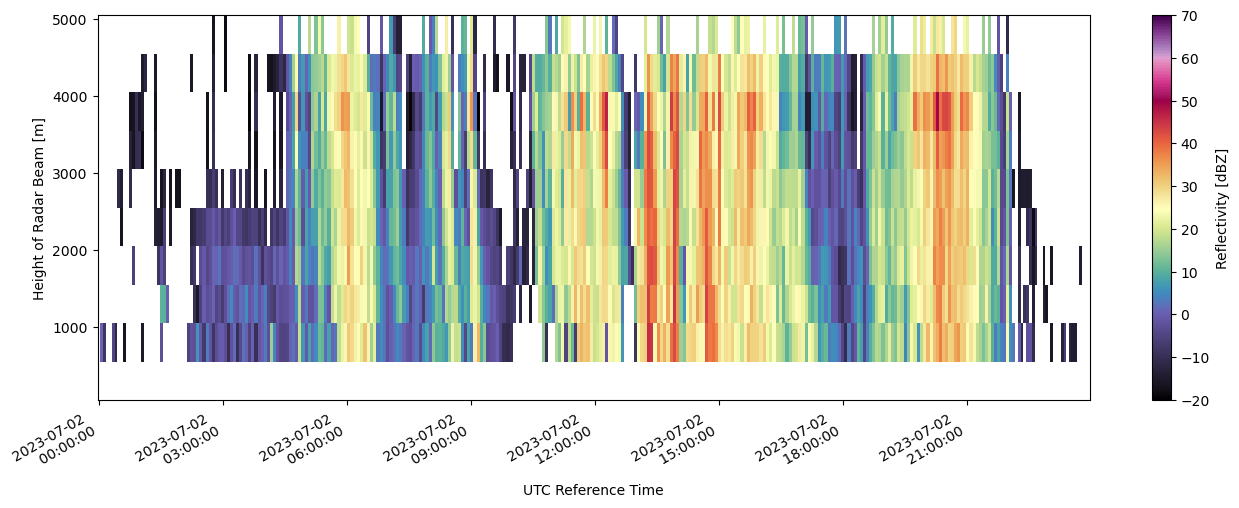

In [31]:
figme = plt.figure(figsize=[16,5]) # creating time series with reflectivity and height over 24 hour UTC period with KLOT data
date_form = mdates.DateFormatter("%Y-%m-%d \n %H:%M:%S")
plt.gca().xaxis.set_major_formatter(date_form) 
ds.reflectivity.plot(y='height',
                     cmap='pyart_ChaseSpectral',
                     vmin=-20,
                     vmax=70)
y = ds.reflectivity # storing value for subplots

## Reading in and Plotting Ceilometer Data from 07/02

<xarray.Dataset>
Dimensions:                            (time: 1440, layer: 5, range: 3276)
Coordinates:
  * time                               (time) datetime64[ns] 2023-07-02T00:00...
  * range                              (range) float64 0.0 4.8 ... 1.572e+04
  * layer                              (layer) float64 1.0 2.0 3.0 4.0 5.0
    longitude                          float64 ...
    latitude                           float64 ...
Data variables: (12/27)
    cloud_base_heights                 (time, layer) float64 ...
    vertical_visibility                (time) float64 ...
    p_pol                              (time, range) float32 ...
    x_pol                              (time, range) float32 ...
    beta_att                           (time, range) float32 ...
    linear_depol_ratio                 (time, range) float32 ...
    ...                                 ...
    receiver_gain                      (time) float32 ...
    range_resolution                   (time) float

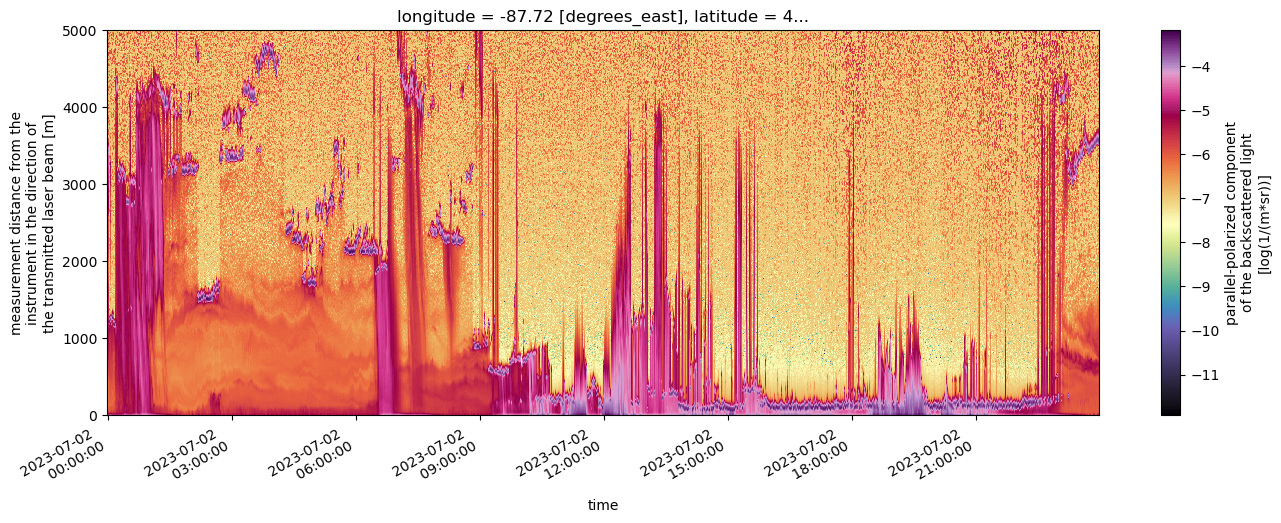

In [32]:
data = '/Users/tehreemqureshi/Downloads/crocus-neiu-ceilometer-a1-202307020000.nc'
ds = xr.open_dataset(data)
print(ds)
da1 = ds.backscatter # storing relevant backscatter and depol values in da1 and da2
da2 = ds.linear_depol_ratio
figme = plt.figure(figsize=[16,5])
da1.plot(x="time", cmap='pyart_ChaseSpectral') # plotting backscatter 
plt.ylim(0, 5000)
date_form = mdates.DateFormatter("%Y-%m-%d \n %H:%M:%S")
plt.gca().xaxis.set_major_formatter(date_form)

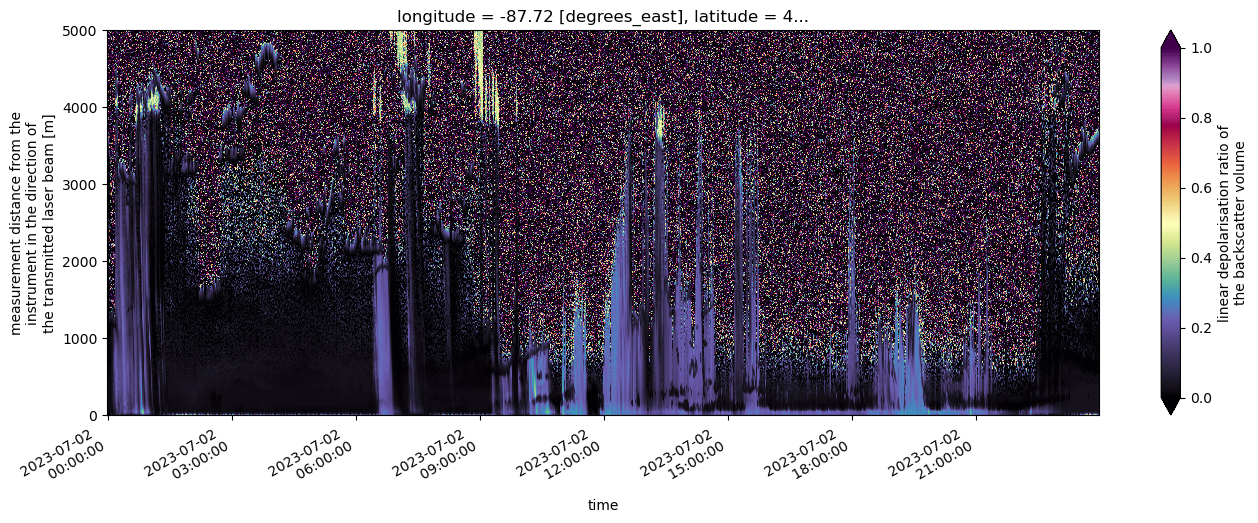

In [33]:
fig = plt.figure(figsize=[16,5])
(da2).plot(x="time", vmin=0,vmax=1, cmap='pyart_ChaseSpectral') # plotting linear depolarization ratio, colormap will be changed in final subplot for improved visibility
plt.ylim(0, 5000)
date_form = mdates.DateFormatter("%Y-%m-%d \n %H:%M:%S")
plt.gca().xaxis.set_major_formatter(date_form)

## Plotting and Reading in Micro Rain Radar from 07/02 (adapted from Adam Abdelhak).

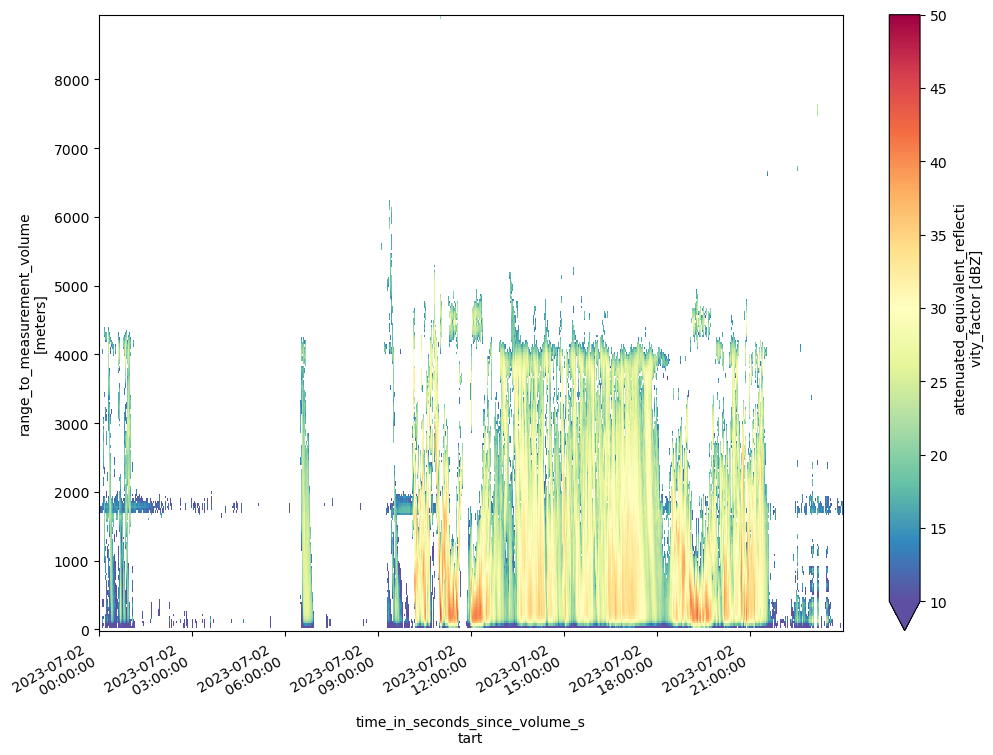

In [42]:
ds = xr.open_mfdataset("/Users/tehreemqureshi/Downloads/mrr-july-2-2023.nc")
fig = plt.figure(figsize = [12, 8])
ds["Zea"].T.plot(cmap='Spectral_r', vmin=10, vmax=50) # plotting Zea, corresponding to reflectivity
date_form = mdates.DateFormatter("%Y-%m-%d \n %H:%M:%S")
plt.gca().xaxis.set_major_formatter(date_form)

## Developing Four Panel Plot of NEXRAD, Ceilometer, and Micro Rain Radar Data over 24 hours on 07/02. 

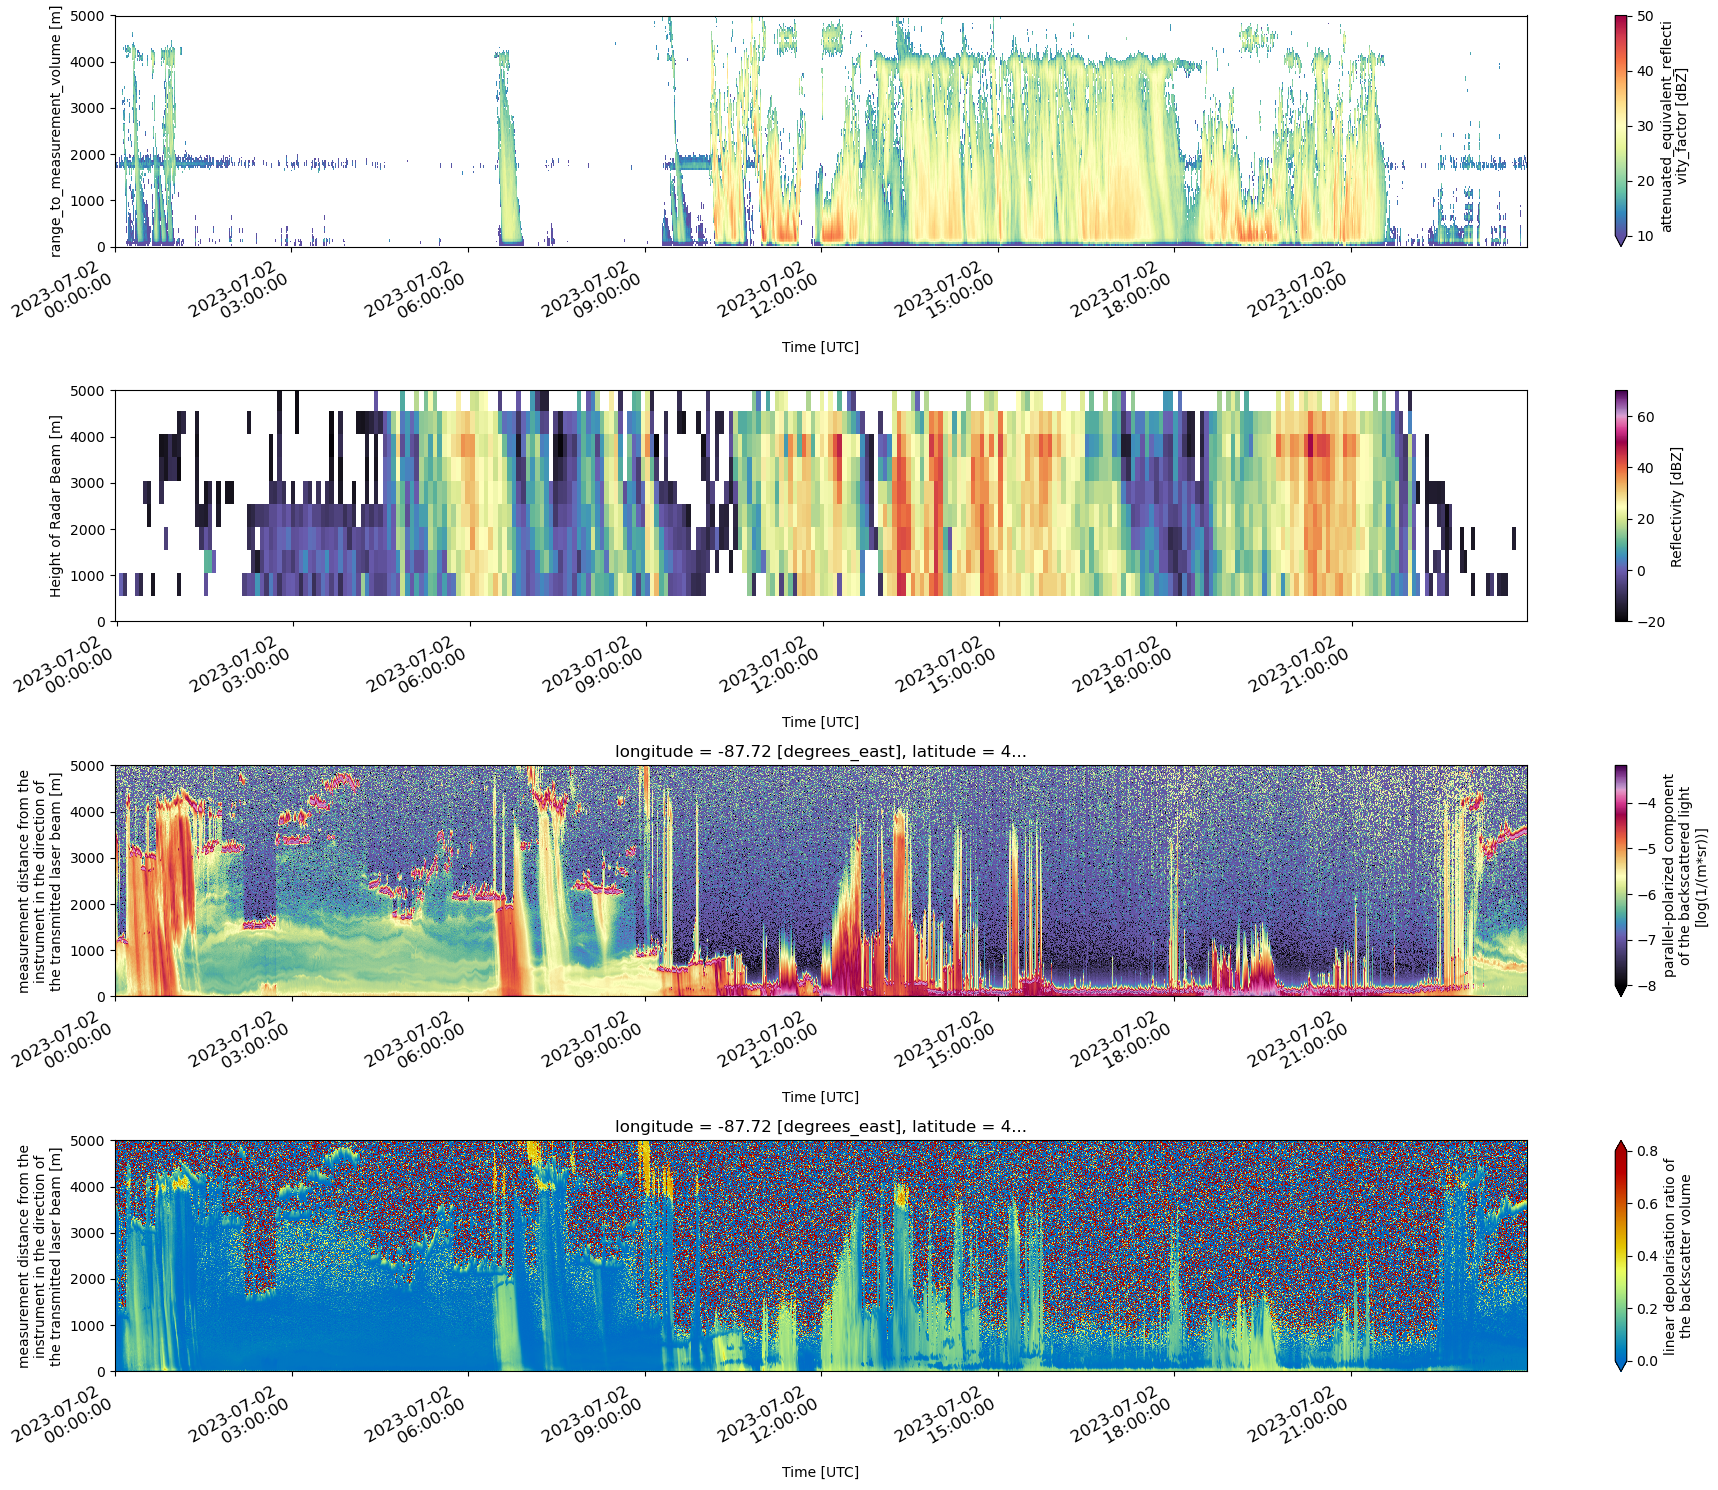

In [43]:
fig = plt.figure(figsize = [19, 15]) # create large enough display 
ax = plt.subplot(411) # plotting MRR as first subplot
ax = ds["Zea"].T.plot(cmap='Spectral_r', vmin=10, vmax=50)
date_form = mdates.DateFormatter("%Y-%m-%d \n %H:%M:%S")
plt.gca().xaxis.set_major_formatter(date_form)
plt.xticks(fontsize=12) # increase in font size
plt.ylim(0, 5000) # 
plt.xlabel('Time [UTC]'), plt.ylabel('range_to_measurement_volume [m]')
ax = plt.subplot(412) # plotting NEXRAD data as second subplot
date_form = mdates.DateFormatter("%Y-%m-%d \n %H:%M:%S")
plt.gca().xaxis.set_major_formatter(date_form)
hg = y.plot(y='height',
                     cmap='pyart_ChaseSpectral',
                     vmin=-20,
                     vmax=70)
plt.xticks(fontsize=12)
plt.ylim(0, 5000)
fig.tight_layout()
plt.xlabel('Time [UTC]')
ax = plt.subplot(413) # plotting CL backscatter as third subplot
ax = da1.plot(x="time", vmin=-8, cmap='pyart_ChaseSpectral')
plt.xticks(fontsize=12)
plt.ylim(0, 5000)
date_form = mdates.DateFormatter("%Y-%m-%d \n %H:%M:%S")
plt.gca().xaxis.set_major_formatter(date_form)
plt.xlabel('Time [UTC]')
ax = plt.subplot(414) # plotting CL linear depolarization ratio as fourth subplot
ax = (da2).plot(x="time", vmin=0, vmax=.8, cmap = 'pyart_HomeyerRainbow') ##vmax for ratio limited to .8 for improved data analysis
plt.xticks(fontsize=12)
plt.ylim(0, 5000)
date_form = mdates.DateFormatter("%Y-%m-%d \n %H:%M:%S")
plt.gca().xaxis.set_major_formatter(date_form)
plt.xlabel('Time [UTC]')
fig.tight_layout() 
plt.show()

---

## Summary
### This notebook reads in and analyzes the July 2nd Chicagoland flood event, reading in and analyzing data from NEXRAD KLOT and the Ceilometer (CL) and Micro Rain Radar (MRR) from Northeastern Illinois University. Plots the relevant values indivudally and concludes with a final four plot figure to be used for value comparison and poster analysis.
### Developed by Tehreem Qureshi, SULI intern for EVS. 